## HEART-MET Assistive Robot Challenge with VideoMae Transformers

Olmer Garcia-Bedoya, Jose Tomas Lorente , Sebastian Murcia

**[Ekumens Inc](https://www.ekumenlabs.com/)**
Copyright 2022- Ekumen Inc. All rights reserved.


In [ ]:
#!pip install torch torchvision torchaudio
import torch
print('gpu?'+str(torch.cuda.is_available()))

### Required packages

Package installed (just one time or in google colab (you do not need all of this packages)

In [2]:
# !pip install --upgrade pip
# !pip install nvidia-pyindex
# !pip install nvidia-tensorrt==8.4.3.1
# !pip install torch-tensorrt==1.2.0 --find-links https://github.com/pytorch/TensorRT/releases/expanded_assets/v1.2.0
# !pip install transformers
# !pip install decord
# !pip install opencv-python
# !pip install pillow
# !pip install torchvision
# !pip install datasets
# !pip install --upgrade requests
# !pip install --upgrade scikit-learn scipy matplotlib

## Load data from zip

It is made the first time to unzip the data. Also work in colab sharing the zip a folder *ICSR 2022 HEART-MET*.

In [3]:
# !mkdir training_set test_set validation_set
# !ls

In [4]:
# !pip install pyunpack
# !pip install patool
# !pip install py7zr

In [5]:
## only google colab

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [6]:
# from pyunpack import Archive
# Archive('training_set.7z').extractall("training_set")
# Archive('test_set.7z').extractall("test_set")
# Archive('validation_set.7z').extractall("validation_set")

In [7]:
## only google colab
#! cp "/content/drive/MyDrive/ICSR 2022 HEART-MET Activity Recognition Challenge/training_labels.json" /content/

### Configuration



In [2]:
names=['Opening the door and walking in/out',
        'Putting on a jacket',
        'Touching a hot surface',
        'Opening the fridge',
        'Drinking water',
        'Colliding against something',
        'Eating food with a fork',
        'Coughing or sneezing',
        'Wiping a table',
        'Reading a book',
        'Neck roll exercise',
        'Freehand exercise',
        'Lying down',
        'Limping',
        'Talking on the phone',
        'Using a computer',
        'Falling down',
        'Brushing teeth',
        'Writing',
        'Unknown activity']

The next code is adapted from (higgingFace->VideMAE-> VideoMAEForVideoClassification)[https://huggingface.co/docs/transformers/main/en/model_doc/videomae#transformers.VideoMAEForVideoClassification]

In [3]:
from decord import VideoReader, cpu
from transformers import VideoMAEFeatureExtractor, VideoMAEForPreTraining,VideoMAEConfig,VideoMAEForVideoClassification
import numpy as np
import torch
import os
import json
import csv #I make in a venv here more easy pandas...

In [4]:
# configuration = VideoMAEConfig({'patch_size':128})
# configuration.return_dict=True

name_model="MCG-NJU/videomae-base-finetuned-kinetics"
#TODO: uncomment to start from the last training model
# name_model="./videomae-icsr-heart-v4"

feature_extractor = VideoMAEFeatureExtractor.from_pretrained(name_model)
# model = VideoMAEForVideoClassification.from_pretrained(name_model)
output=json.load(open('training_labels.json'))
validation_labels = json.load(open('validation_labels.json'))
path='training_set'
validation_path='validation_set'


## Fine tuning VideoMAE

Fine tuning is the gold of transformers, from few videos/images/sentences we can make a classifier.

VideoMAE is based of a ImageMAE which is based in ViT (Vision Transformer), which is Based in Transformers, so let try.




### Create DataSet

based in [image dataset](https://huggingface.co/docs/datasets/image_dataset). I think that it is not used in the best way the library [link text](https://huggingface.co/course/chapter5/4?fw=pt)

In [15]:
# !pip install --upgrade transformers decord datasets
# !pip install --upgrade numpy

In [5]:
from datasets import Dataset
import numpy as np

my_set=[{'file_name':path+'/'+a,'labels':output[a][0],'description':names[output[a][0]]} for a in output.keys()]
validation_set=[{'file_name':validation_path+'/'+a,'labels':validation_labels[a][0],'description':names[validation_labels[a][0]]} for a in validation_labels.keys()]

In [6]:
len(validation_set)

136

In [7]:
len(my_set)

792

In [8]:

full_augmented_set = {}
full_augmented_set['train'] = my_set
full_augmented_set['validation'] = validation_set

with open("train_set.json", "w") as final:
    json.dump(full_augmented_set, final)


In [9]:
# dataset = Dataset.from_json('train.json',field='train')
# dataset_validation = Dataset.from_json('train.json',field='validation')
# dataset_full = Dataset.from_json('full_train.json', field='train')
dataset = Dataset.from_json('train_set.json',field='train')
dataset_validation = Dataset.from_json('train_set.json',field='validation')

Using custom data configuration default-8ba53836c2ef3b22


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Using custom data configuration default-647a4d18c15a46f8


Dataset json downloaded and prepared to /home/tomas/.cache/huggingface/datasets/json/default-8ba53836c2ef3b22/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/tomas/.cache/huggingface/datasets/json/default-647a4d18c15a46f8/0.0.0. Subsequent calls will reuse this data.


In [10]:
dataset[0]


{'file_name': 'training_set/video0000.mp4',
 'labels': 14,
 'description': 'Talking on the phone'}

### Training and validation

Based in [Fine tuning ViT](https://huggingface.co/blog/fine-tune-vit)

####  sampling of the video

In [18]:
# after many epochs 48 , it our validation give 0.71, but in the competition give 0.69
# may be will be better to create a collate for test and other for training to get a better result during the simulation
# this issu describe what todo https://github.com/huggingface/transformers/issues/13993, rewrite the function get_Data_allocation of the Trainer class (just inheritance) 
import torch
def collate_with_path_batches(batch):
    pixel_values = []
    labels = []
    for elem in batch:
        file_path = elem['file_name']
        videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
        videoreader.seek(0)
        frames = len(videoreader)
        n_frames = 16
        ##not improve nothing#send a fast motion video, like a crop!!
        #random_speed = np.random.randint(0, 4)*n_frames
        #frames=frames-random_speed
        #initial_index = np.random.randint(0, n_frames+random_speed-1)
        #indices = np.linspace(initial_index, frames-n_frames, num=n_frames)
        
        initial_index = np.random.randint(0, n_frames)        
        
        indices = np.linspace(initial_index, frames, num=n_frames)
        indices = np.clip(indices, initial_index, frames- 1).astype(np.int64)
        #TODO: add image augmentation
        pixel_values.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
        labels.append(elem['labels'])
    return {
        'pixel_values': torch.stack(pixel_values),
        'labels': torch.tensor(labels)
    }

In [19]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [20]:
labels = names

model = VideoMAEForVideoClassification.from_pretrained(
    name_model,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
#     patch_size = 32,
#     num_frames = 64
)

loading configuration file ./videomae-icsr-heart-v4/config.json
Model config VideoMAEConfig {
  "_name_or_path": "MCG-NJU/videomae-base-finetuned-kinetics",
  "architectures": [
    "VideoMAEForVideoClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 384,
  "decoder_intermediate_size": 1536,
  "decoder_num_attention_heads": 6,
  "decoder_num_hidden_layers": 4,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Opening the door and walking in/out",
    "1": "Putting on a jacket",
    "10": "Neck roll exercise",
    "11": "Freehand exercise",
    "12": "Lying down",
    "13": "Limping",
    "14": "Talking on the phone",
    "15": "Using a computer",
    "16": "Falling down",
    "17": "Brushing teeth",
    "18": "Writing",
    "19": "Unknown activity",
    "2": "Touching a hot surface",
    "3": "Opening the fridge",
    "4": "Drinking water",
    "5": "Colliding against something",
    "6": "Eating food 

In [21]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if 'videomae' in name:
            param.requires_grad = False
            
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc_norm.weight
fc_norm.bias
classifier.weight
classifier.bias


In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./videomae-icsr-heart-v5",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=48,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  weight_decay =0.05,
  learning_rate=1e-4,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
  optim="adamw_torch"
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [47]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#   output_dir="./videomae-icsr-heart",
#   per_device_train_batch_size=2,
#   num_train_epochs=16,
#   save_steps=198,
#   logging_steps=198,
#   save_total_limit=5,
#   remove_unused_columns=False,
# )

In [23]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_with_path_batches,
    compute_metrics=compute_metrics,
    train_dataset=dataset,
    eval_dataset=dataset_validation,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [23]:
torch.cuda.empty_cache()

In [24]:
train_results = trainer.train()

***** Running training *****
  Num examples = 792
  Num Epochs = 48
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2400
  Number of trainable parameters = 16916


Step,Training Loss,Validation Loss,Accuracy
100,0.317400,0.989823,0.705882
200,0.299600,0.988221,0.713235
300,0.276200,0.982505,0.720588
400,0.266800,0.963977,0.713235
500,0.251600,0.966964,0.698529
600,0.240900,0.958635,0.705882
700,0.232100,0.952057,0.705882
800,0.224700,0.939365,0.698529
900,0.216100,0.938234,0.705882
1000,0.208900,0.927718,0.705882


***** Running Evaluation *****
  Num examples = 136
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart-v5/checkpoint-100
Configuration saved in ./videomae-icsr-heart-v5/checkpoint-100/config.json
Model weights saved in ./videomae-icsr-heart-v5/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 136
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart-v5/checkpoint-200
Configuration saved in ./videomae-icsr-heart-v5/checkpoint-200/config.json
Model weights saved in ./videomae-icsr-heart-v5/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart-v5/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 136
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart-v5/checkpoint-300
Configuration saved in ./videomae-icsr-heart-v5/checkpoint-300/config.json
Model weights save

#### Saving the model

In [25]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to ./videomae-icsr-heart-v5
Configuration saved in ./videomae-icsr-heart-v5/config.json
Model weights saved in ./videomae-icsr-heart-v5/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart-v5/preprocessor_config.json


***** train metrics *****
  epoch                    =          48.0
  total_flos               = 44124196877GF
  train_loss               =         0.211
  train_runtime            =    1:10:33.49
  train_samples_per_second =          8.98
  train_steps_per_second   =         0.567


In [26]:
metrics = trainer.evaluate(dataset_validation)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 136
  Batch size = 16


***** eval metrics *****
  epoch                   =       48.0
  eval_accuracy           =     0.6985
  eval_loss               =     0.9059
  eval_runtime            = 0:00:13.63
  eval_samples_per_second =      9.976
  eval_steps_per_second   =       0.66


In [27]:
metrics

{'eval_loss': 0.9059243202209473,
 'eval_accuracy': 0.6985294117647058,
 'eval_runtime': 13.6332,
 'eval_samples_per_second': 9.976,
 'eval_steps_per_second': 0.66,
 'epoch': 48.0}

In [28]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "video-classification",
    "dataset": 'HEART-MET',
    "tags": ['video-classification'],
}

trainer.create_model_card(**kwargs)

In [50]:
## only for google colab
#!cp -R /content/videomae-icsr-heart/ /content/drive/MyDrive/ICSR 2022 HEART-MET Activity Recognition Challenge/models
# !cp -R /content/videomae-icsr-heart/ /content/drive/MyDrive/models/

## Testing (with validation)

In [29]:
i=0
predicted=[]

for data in full_augmented_set['validation']:
  #if i==2:
  #  break
  i+=1
  videoreader = VideoReader(data['file_name'], num_threads=1, ctx=cpu(0))
  videoreader.seek(0)
  #indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
  indices = np.linspace(0, len(videoreader), num=16)
  indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
  pixel_values = feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")
  pixel_values = pixel_values.to('cuda')
  with torch.no_grad():
        outputs = model(**pixel_values)#
        pred=outputs.logits.argmax(-1).item()
        predicted.append([data['file_name'],data['labels'],data['description'],pred])
        #eval_results[] =
        #print(data['labels'],pred)
  



In [31]:
import pandas as pd
df = pd.DataFrame(predicted,columns=['file','label','description','predicted'])

df

,file,label,description,predicted
0,validation_set/video0000.mp4,8,Wiping a table,8
1,validation_set/video0001.mp4,18,Writing,18
2,validation_set/video0002.mp4,10,Neck roll exercise,10
3,validation_set/video0003.mp4,7,Coughing or sneezing,4
4,validation_set/video0004.mp4,18,Writing,18
...,...,...,...,...
131,validation_set/video0131.mp4,10,Neck roll exercise,4
132,validation_set/video0132.mp4,14,Talking on the phone,14
133,validation_set/video0133.mp4,2,Touching a hot surface,2
134,validation_set/video0134.mp4,9,Reading a book,9


In [32]:
from sklearn.metrics import classification_report

print(classification_report(df['label'], df['predicted'], target_names=names))


                                     precision    recall  f1-score   support

Opening the door and walking in/out       0.83      0.83      0.83         6
                Putting on a jacket       0.80      0.80      0.80         5
             Touching a hot surface       0.50      0.50      0.50         6
                 Opening the fridge       0.67      0.86      0.75         7
                     Drinking water       0.60      0.90      0.72        10
        Colliding against something       0.50      0.57      0.53         7
            Eating food with a fork       0.64      0.88      0.74         8
               Coughing or sneezing       0.25      0.33      0.29         6
                     Wiping a table       1.00      0.50      0.67         6
                     Reading a book       1.00      0.75      0.86         8
                 Neck roll exercise       0.86      0.86      0.86         7
                  Freehand exercise       0.00      0.00      0.00         

/home/tomas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


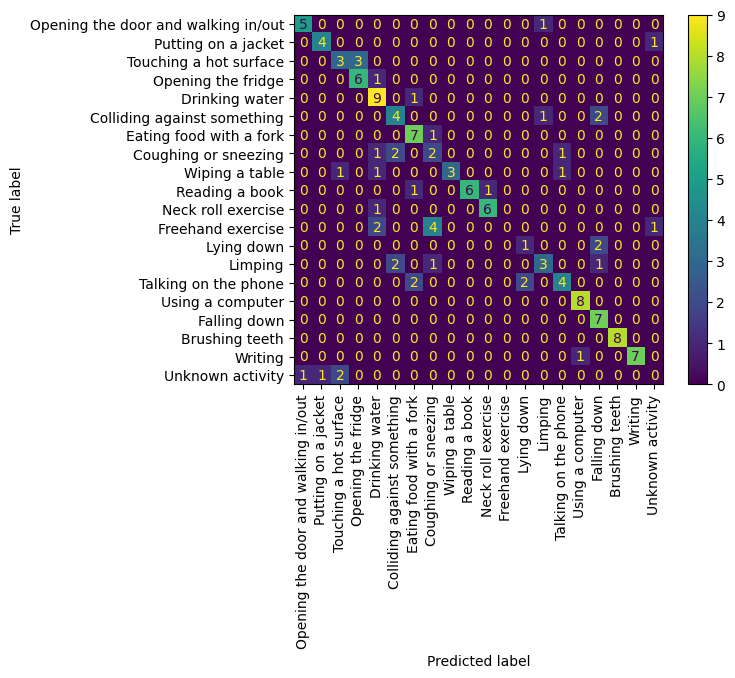

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,ConfusionMatrixDisplay
cm = confusion_matrix(df['label'], df['predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)
disp.plot(xticks_rotation='vertical')

In [35]:
df.to_csv("tes_fast_motion.csv",index=False)

In [34]:
eval_results = {}
for row in predicted:
    eval_results[row[0]]="["+str(row[-1])+"]"

In [35]:
with open("validation_result_o.json", "w") as outfile:
    json.dump(eval_results, outfile)

## Test data


In [40]:
import os
import glob
videos = sorted(glob.glob('test_set' + '/*.mp4'))

i=0
predicted=[]

for video in videos:
  #if i==2:
  #  break
  i+=1
  print(video)
  try:
      videoreader = VideoReader(video, num_threads=1, ctx=cpu(0))
      videoreader.seek(0)
      #indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
      n_frames = 16        
      initial_index = 0 #np.random.randint(0, n_frames)
      indices = np.linspace(initial_index, len(videoreader), num=n_frames)
      indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
      pixel_values = feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")
      pixel_values = pixel_values.to('cuda')
      with torch.no_grad():
            outputs = model(**pixel_values)#
            pred=outputs.logits.argmax(-1).item()
            predicted.append([video,pred])
  except:
      predicted.append([video,19])


test_set/video0000.mp4
test_set/video0001.mp4
test_set/video0002.mp4
test_set/video0003.mp4
test_set/video0004.mp4
test_set/video0005.mp4
test_set/video0006.mp4
test_set/video0007.mp4
test_set/video0008.mp4
test_set/video0009.mp4
test_set/video0010.mp4
test_set/video0011.mp4
test_set/video0012.mp4
test_set/video0013.mp4
test_set/video0014.mp4
test_set/video0015.mp4
test_set/video0016.mp4
test_set/video0017.mp4
test_set/video0018.mp4
test_set/video0019.mp4
test_set/video0020.mp4
test_set/video0021.mp4
test_set/video0022.mp4
test_set/video0023.mp4
test_set/video0024.mp4
test_set/video0025.mp4
test_set/video0026.mp4
test_set/video0027.mp4
test_set/video0028.mp4
test_set/video0029.mp4
test_set/video0030.mp4
test_set/video0031.mp4
test_set/video0032.mp4
test_set/video0033.mp4
test_set/video0034.mp4
test_set/video0035.mp4
test_set/video0036.mp4
test_set/video0037.mp4
test_set/video0038.mp4
test_set/video0039.mp4
test_set/video0040.mp4
test_set/video0041.mp4
test_set/video0042.mp4
test_set/vi

In [41]:
## TODO: I remove by hand the folder and the "" 
eval_results = {}
for row in predicted:
    eval_results[row[0]]="["+str(row[-1])+"]"
    
with open("test_result_o.json", "w") as outfile:
    json.dump(eval_results, outfile)